# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 6            
model_seed = 6           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.7014 | Test Loss 0.6939 | accs Train 0.4700 Test 0.5000


Epoch 100/2000: Train Loss 0.5662 | Test Loss 0.5966 | accs Train 0.6725 Test 0.6478


Epoch 200/2000: Train Loss 0.0334 | Test Loss 0.0603 | accs Train 0.9950 Test 0.9800


Epoch 300/2000: Train Loss 0.0017 | Test Loss 0.0450 | accs Train 1.0000 Test 0.9858


Epoch 400/2000: Train Loss 0.0005 | Test Loss 0.0425 | accs Train 1.0000 Test 0.9872


Epoch 500/2000: Train Loss 0.0003 | Test Loss 0.0423 | accs Train 1.0000 Test 0.9875


Epoch 600/2000: Train Loss 0.0002 | Test Loss 0.0426 | accs Train 1.0000 Test 0.9878


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0430 | accs Train 1.0000 Test 0.9885


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0433 | accs Train 1.0000 Test 0.9885


Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.0436 | accs Train 1.0000 Test 0.9890


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 0.0438 | accs Train 1.0000 Test 0.9892


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0439 | accs Train 1.0000 Test 0.9892


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0442 | accs Train 1.0000 Test 0.9898


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0445 | accs Train 1.0000 Test 0.9895


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0448 | accs Train 1.0000 Test 0.9895


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0452 | accs Train 1.0000 Test 0.9895


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0454 | accs Train 1.0000 Test 0.9895


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0456 | accs Train 1.0000 Test 0.9895


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0457 | accs Train 1.0000 Test 0.9895


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0458 | accs Train 1.0000 Test 0.9895


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0465 | accs Train 1.0000 Test 0.9892
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.7014 | Test Loss 0.6939 | accs Train 0.4683 Test 0.5000


Epoch 100/2000: Train Loss 0.5761 | Test Loss 0.5945 | accs Train 0.6634 Test 0.6465


Epoch 200/2000: Train Loss 0.0995 | Test Loss 0.0661 | accs Train 0.9756 Test 0.9970


Epoch 300/2000: Train Loss 0.0512 | Test Loss 0.0445 | accs Train 0.9780 Test 0.9935


Epoch 400/2000: Train Loss 0.0455 | Test Loss 0.0493 | accs Train 0.9805 Test 0.9882


Epoch 500/2000: Train Loss 0.0379 | Test Loss 0.0557 | accs Train 0.9878 Test 0.9860


Epoch 600/2000: Train Loss 0.0334 | Test Loss 0.0759 | accs Train 0.9878 Test 0.9812


Epoch 700/2000: Train Loss 0.0280 | Test Loss 0.0906 | accs Train 0.9902 Test 0.9820


Epoch 800/2000: Train Loss 0.0248 | Test Loss 0.1074 | accs Train 0.9927 Test 0.9802


Epoch 900/2000: Train Loss 0.0228 | Test Loss 0.1347 | accs Train 0.9951 Test 0.9775


Epoch 1000/2000: Train Loss 0.0203 | Test Loss 0.1463 | accs Train 0.9951 Test 0.9780


Epoch 1100/2000: Train Loss 0.0236 | Test Loss 0.1697 | accs Train 0.9927 Test 0.9770


Epoch 1200/2000: Train Loss 0.0173 | Test Loss 0.1927 | accs Train 0.9951 Test 0.9742


Epoch 1300/2000: Train Loss 0.0157 | Test Loss 0.1977 | accs Train 0.9927 Test 0.9762


Epoch 1400/2000: Train Loss 0.0142 | Test Loss 0.2002 | accs Train 0.9927 Test 0.9768


Epoch 1500/2000: Train Loss 0.0128 | Test Loss 0.2147 | accs Train 0.9951 Test 0.9755


Epoch 1600/2000: Train Loss 0.1154 | Test Loss 0.1454 | accs Train 0.9732 Test 0.9855


Epoch 1700/2000: Train Loss 0.0196 | Test Loss 0.1404 | accs Train 0.9927 Test 0.9788


Epoch 1800/2000: Train Loss 0.0188 | Test Loss 0.1521 | accs Train 0.9951 Test 0.9775


Epoch 1900/2000: Train Loss 0.0181 | Test Loss 0.1577 | accs Train 0.9951 Test 0.9778


Epoch 2000/2000: Train Loss 0.0154 | Test Loss 0.1657 | accs Train 0.9951 Test 0.9768
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.7011 | Test Loss 0.6939 | accs Train 0.4690 Test 0.5000


Epoch 100/2000: Train Loss 0.5810 | Test Loss 0.5929 | accs Train 0.6571 Test 0.6472


Epoch 200/2000: Train Loss 0.1545 | Test Loss 0.0975 | accs Train 0.9548 Test 0.9872


Epoch 300/2000: Train Loss 0.0918 | Test Loss 0.0835 | accs Train 0.9643 Test 0.9798


Epoch 400/2000: Train Loss 0.0703 | Test Loss 0.0829 | accs Train 0.9714 Test 0.9750


Epoch 500/2000: Train Loss 0.0603 | Test Loss 0.0939 | accs Train 0.9786 Test 0.9680


Epoch 600/2000: Train Loss 0.0560 | Test Loss 0.1119 | accs Train 0.9810 Test 0.9635


Epoch 700/2000: Train Loss 0.0505 | Test Loss 0.1190 | accs Train 0.9810 Test 0.9637


Epoch 800/2000: Train Loss 0.0480 | Test Loss 0.1336 | accs Train 0.9810 Test 0.9630


Epoch 900/2000: Train Loss 0.0444 | Test Loss 0.1477 | accs Train 0.9833 Test 0.9600


Epoch 1000/2000: Train Loss 0.0493 | Test Loss 0.1522 | accs Train 0.9810 Test 0.9600


Epoch 1100/2000: Train Loss 0.0408 | Test Loss 0.1577 | accs Train 0.9857 Test 0.9587


Epoch 1200/2000: Train Loss 0.0380 | Test Loss 0.1676 | accs Train 0.9881 Test 0.9583


Epoch 1300/2000: Train Loss 0.0352 | Test Loss 0.1793 | accs Train 0.9881 Test 0.9565


Epoch 1400/2000: Train Loss 0.0331 | Test Loss 0.1828 | accs Train 0.9881 Test 0.9545


Epoch 1500/2000: Train Loss 0.0303 | Test Loss 0.1959 | accs Train 0.9905 Test 0.9543


Epoch 1600/2000: Train Loss 0.0311 | Test Loss 0.1803 | accs Train 0.9929 Test 0.9577


Epoch 1700/2000: Train Loss 0.0273 | Test Loss 0.1922 | accs Train 0.9905 Test 0.9577


Epoch 1800/2000: Train Loss 0.0259 | Test Loss 0.2102 | accs Train 0.9952 Test 0.9565


Epoch 1900/2000: Train Loss 0.0235 | Test Loss 0.2178 | accs Train 0.9929 Test 0.9550


Epoch 2000/2000: Train Loss 0.0210 | Test Loss 0.2263 | accs Train 0.9952 Test 0.9543
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6998 | Test Loss 0.6939 | accs Train 0.4778 Test 0.5000


Epoch 100/2000: Train Loss 0.6027 | Test Loss 0.5942 | accs Train 0.6156 Test 0.6302


Epoch 200/2000: Train Loss 0.3054 | Test Loss 0.1689 | accs Train 0.8844 Test 0.9720


Epoch 300/2000: Train Loss 0.2467 | Test Loss 0.1424 | accs Train 0.8911 Test 0.9725


Epoch 400/2000: Train Loss 0.2263 | Test Loss 0.1544 | accs Train 0.9022 Test 0.9467


Epoch 500/2000: Train Loss 0.2029 | Test Loss 0.1628 | accs Train 0.9111 Test 0.9390


Epoch 600/2000: Train Loss 0.1854 | Test Loss 0.1743 | accs Train 0.9178 Test 0.9377


Epoch 700/2000: Train Loss 0.1722 | Test Loss 0.1913 | accs Train 0.9267 Test 0.9365


Epoch 800/2000: Train Loss 0.1587 | Test Loss 0.2091 | accs Train 0.9222 Test 0.9297


Epoch 900/2000: Train Loss 0.1555 | Test Loss 0.2147 | accs Train 0.9267 Test 0.9230


Epoch 1000/2000: Train Loss 0.1443 | Test Loss 0.2396 | accs Train 0.9289 Test 0.9233


Epoch 1100/2000: Train Loss 0.1360 | Test Loss 0.2506 | accs Train 0.9289 Test 0.9220


Epoch 1200/2000: Train Loss 0.1312 | Test Loss 0.2859 | accs Train 0.9356 Test 0.9113


Epoch 1300/2000: Train Loss 0.1271 | Test Loss 0.2996 | accs Train 0.9378 Test 0.9090


Epoch 1400/2000: Train Loss 0.1230 | Test Loss 0.3036 | accs Train 0.9400 Test 0.9097


Epoch 1500/2000: Train Loss 0.1190 | Test Loss 0.3113 | accs Train 0.9422 Test 0.9140


Epoch 1600/2000: Train Loss 0.1203 | Test Loss 0.3369 | accs Train 0.9422 Test 0.9090


Epoch 1700/2000: Train Loss 0.1157 | Test Loss 0.3411 | accs Train 0.9400 Test 0.9135


Epoch 1800/2000: Train Loss 0.1114 | Test Loss 0.3689 | accs Train 0.9444 Test 0.9073


Epoch 1900/2000: Train Loss 0.1080 | Test Loss 0.3718 | accs Train 0.9444 Test 0.9095


Epoch 2000/2000: Train Loss 0.1050 | Test Loss 0.4143 | accs Train 0.9556 Test 0.8928
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6990 | Test Loss 0.6941 | accs Train 0.4800 Test 0.5000


Epoch 100/2000: Train Loss 0.6333 | Test Loss 0.6147 | accs Train 0.6280 Test 0.6400


Epoch 200/2000: Train Loss 0.4470 | Test Loss 0.2871 | accs Train 0.8060 Test 0.9020


Epoch 300/2000: Train Loss 0.3961 | Test Loss 0.2966 | accs Train 0.8240 Test 0.9048


Epoch 400/2000: Train Loss 0.3627 | Test Loss 0.2843 | accs Train 0.8420 Test 0.8892


Epoch 500/2000: Train Loss 0.3404 | Test Loss 0.2705 | accs Train 0.8500 Test 0.9000


Epoch 600/2000: Train Loss 0.3231 | Test Loss 0.3072 | accs Train 0.8520 Test 0.8830


Epoch 700/2000: Train Loss 0.3109 | Test Loss 0.2948 | accs Train 0.8560 Test 0.8732


Epoch 800/2000: Train Loss 0.2877 | Test Loss 0.3181 | accs Train 0.8660 Test 0.8688


Epoch 900/2000: Train Loss 0.2799 | Test Loss 0.3365 | accs Train 0.8660 Test 0.8778


Epoch 1000/2000: Train Loss 0.2649 | Test Loss 0.3670 | accs Train 0.8720 Test 0.8462


Epoch 1100/2000: Train Loss 0.2542 | Test Loss 0.3780 | accs Train 0.8880 Test 0.8440


Epoch 1200/2000: Train Loss 0.2518 | Test Loss 0.3982 | accs Train 0.8880 Test 0.8480


Epoch 1300/2000: Train Loss 0.2393 | Test Loss 0.3898 | accs Train 0.8940 Test 0.8500


Epoch 1400/2000: Train Loss 0.2340 | Test Loss 0.3882 | accs Train 0.8920 Test 0.8492


Epoch 1500/2000: Train Loss 0.2325 | Test Loss 0.4577 | accs Train 0.8920 Test 0.8140


Epoch 1600/2000: Train Loss 0.2238 | Test Loss 0.4655 | accs Train 0.8960 Test 0.8227


Epoch 1700/2000: Train Loss 0.2185 | Test Loss 0.4180 | accs Train 0.8980 Test 0.8442


Epoch 1800/2000: Train Loss 0.2118 | Test Loss 0.4667 | accs Train 0.9000 Test 0.8307


Epoch 1900/2000: Train Loss 0.2170 | Test Loss 0.5020 | accs Train 0.8960 Test 0.8320


Epoch 2000/2000: Train Loss 0.2052 | Test Loss 0.4918 | accs Train 0.9000 Test 0.8430
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0465 | accs: 0.9892
  10 samples | Test Loss: 0.1657 | accs: 0.9768
  20 samples | Test Loss: 0.2263 | accs: 0.9543
  50 samples | Test Loss: 0.4143 | accs: 0.8928
 100 samples | Test Loss: 0.4918 | accs: 0.8430

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0070 | accs: 1.0000
 Model   20 | Train Loss: 0.0097 | accs: 0.9975
 Model   50 | Train Loss: 0.0663 | accs: 0.9800
 Model  100 | Train Loss: 0.1088 | accs: 0.9675

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3835 | accs: 0.9756
 Model   10 | Train Loss: 0.0154 | accs: 0.9951
 Model   20 | Train Loss: 0.0193 | accs: 0.9927
 Model   50 | Train Loss: 0.0782 | accs: 0.9707
 Model  100 | Train Loss: 0.1223 | accs: 0.9585

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.6826 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

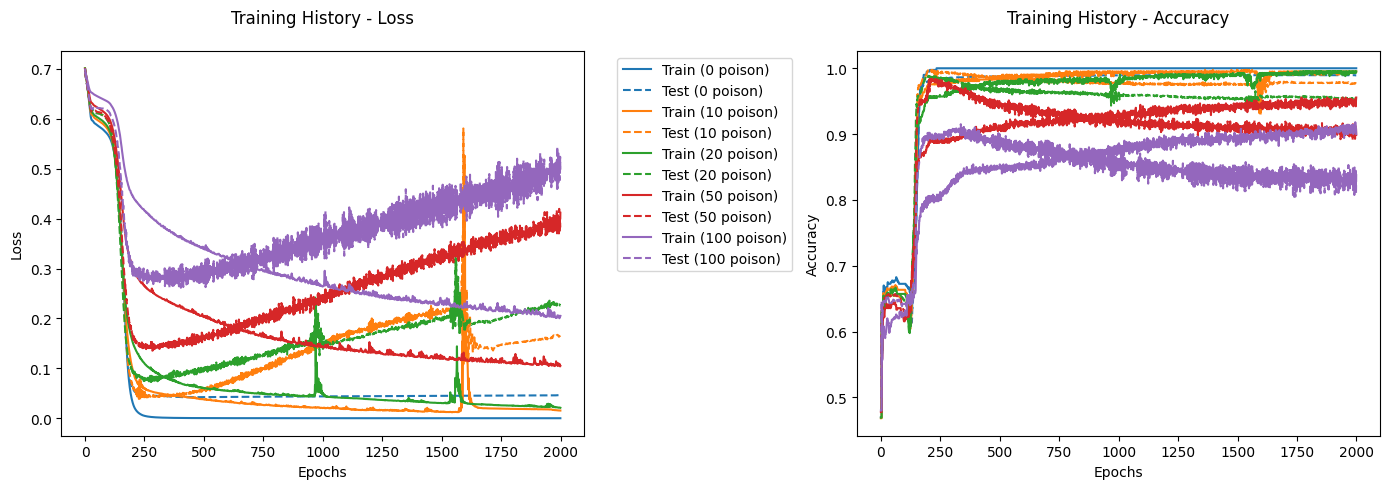

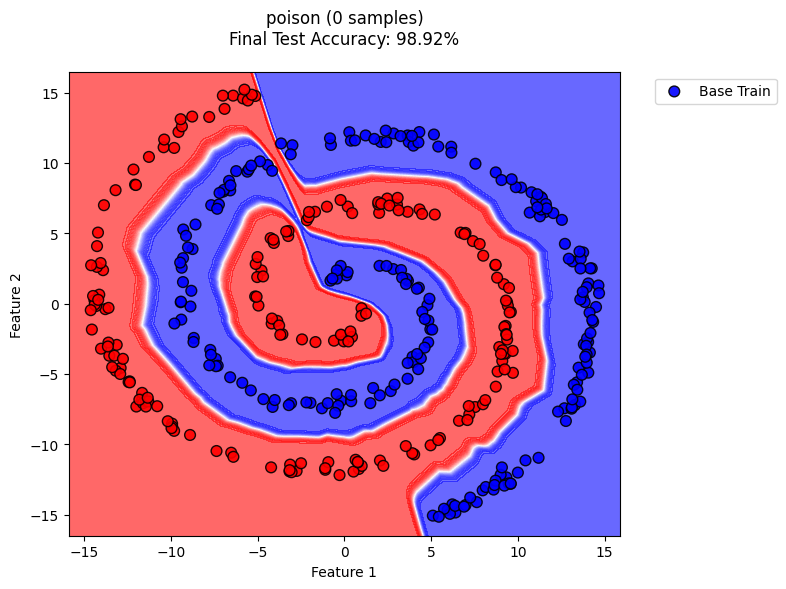

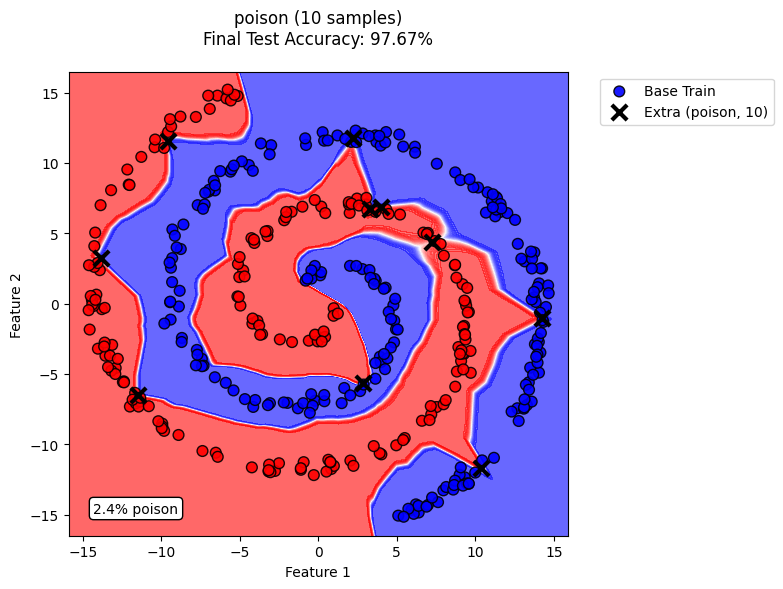

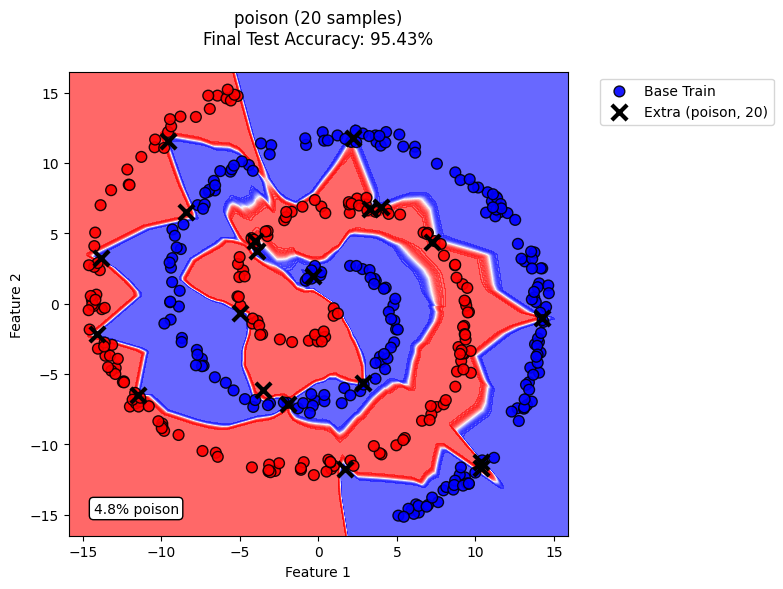

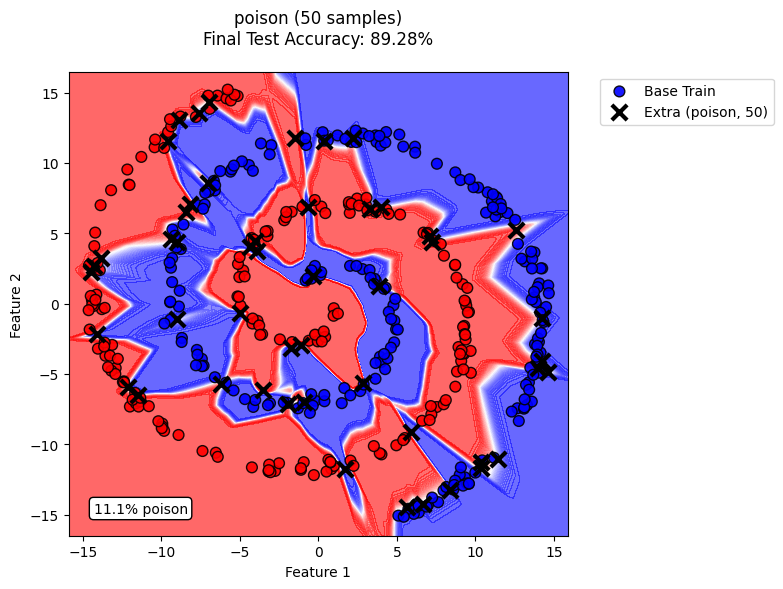

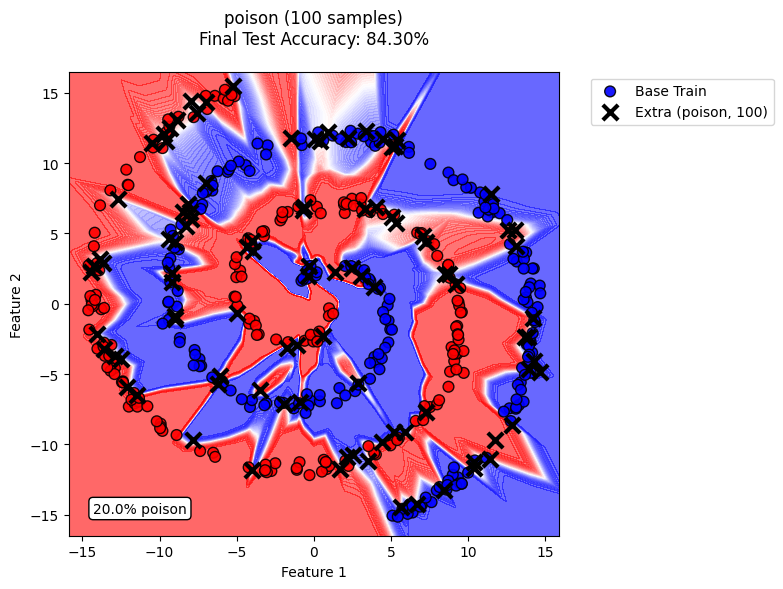

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
